<a href="https://colab.research.google.com/github/h0w4rds/brief-analysis/blob/main/beta-binomial-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Alternative Way to Present Proportion Results**

These notes cover section 2.4. We don't need any data for this set.

 
This set of notes introduces the Beta-Binomial Model to replace Wald confidence intervals for proportions.  This a Bayesian method of analysis and is used in popular A/B testing software like Google Analytics.


We already discussed using the form of the prop.test() that includes the correct=TRUE option, which helps with the Wald Confidence interval.  But what is so wrong with good old Wald?

It is particularly bad when the proportions are small.  Here is what we mean.  By definition a 95% confident interval should contain the true proportion, $\pi$, 95% of the time.  The small simulation below calculates 10,000 Wald confidence interval for samples of $n=50$. We would expect that out of those 10,000, 9,500 of them would contain the true parameter. 
 
In the code below the truth is $p$.  phat=$\hat{p}$ calculated from each sample (this is what you would do in real life because you would not know the true parameter).




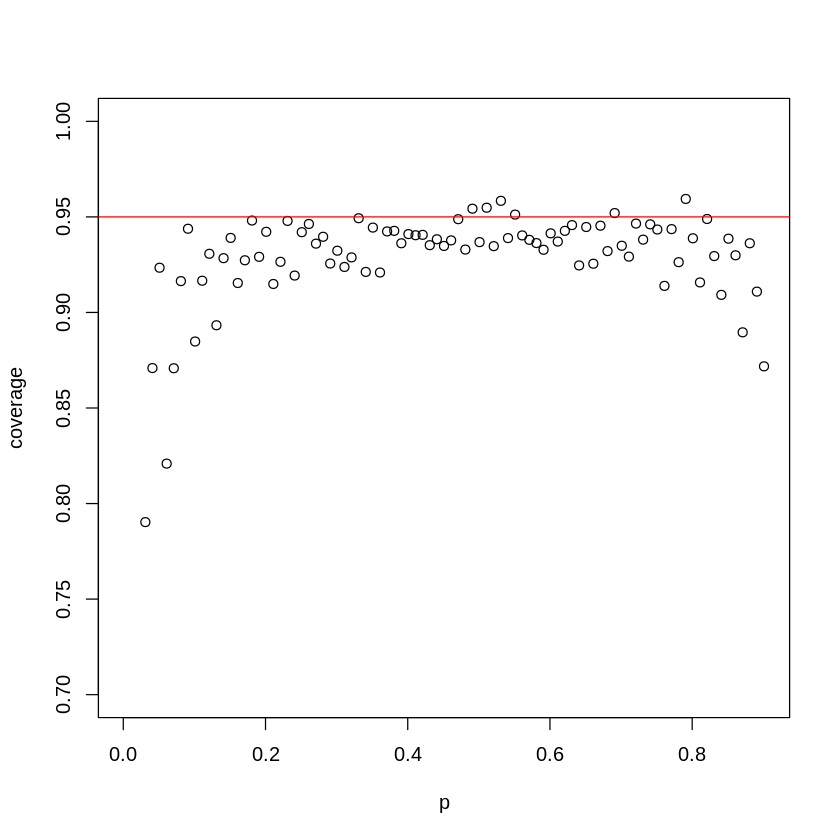

In [ ]:
z<-qnorm(0.975)
n=50 # sample size
p<-seq(0.001,0.91,0.01) # different values of sample proportion
iter=10000
coverage<-c()
for (i in 1:length(p)){
  sample<-rbinom(iter,n,p[i]) # takes a sample of data generated from a particular p value
  phat<-sample/n # confidence interval
  lower=phat-z*sqrt(phat*(1-phat)/n) # lower bound
  upper=phat+z*sqrt(phat*(1-phat)/n) # upper bound
  count<-ifelse(lower<p[i] & p[i]<upper, 1, 0)
  coverage[i]<-sum(count)/iter
  
}

plot(p, coverage, ylim=c(0.7,1))
abline(h=0.95, col="red")


Hmm.  Notice, in most cases the coverage (its not technically coverage probability but we will call it that for now) is not 95%.
 
This is particularly problematic for us because the experiments we have been discussing are most likely going to have a small proportion.


# **Beta Binomial Model**

The beta-binomial model provides an alternative way to assess our uncertainty about the sample proportion, $\hat{p}$ when the data are binary.  
 
We will represent our beliefs about the true proportion, $\pi$ using a beta distribution.  The beta distribution ranges [0,1] and is very flexible.


$$P(\pi)=\frac{\pi^{a-1}(1-\pi)^{(b-1)}}{\beta(a,b)} $$ and

$$\beta(a,b)=\frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)} $$ and the $\Gamma$ function says to

$$\Gamma(z)=\int_{0}^{\infty} x^{z-1}e^{-x} dx $$.

Don't panic.  We can use R!  And there are a qbeta, rbeta and dbeta functions!

Here is what this distribution looks like.

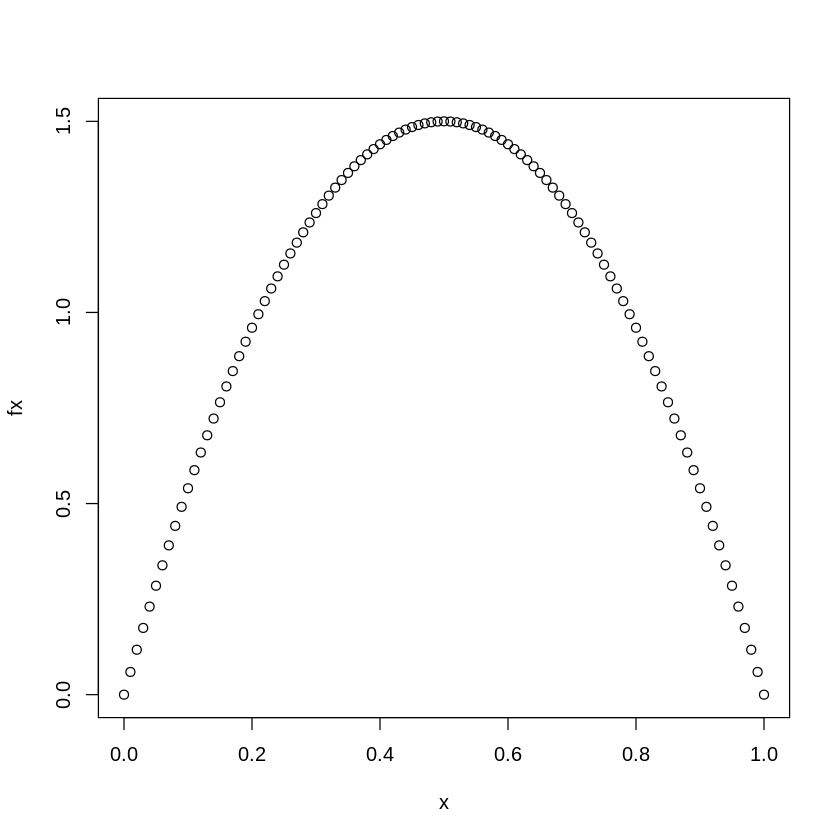

In [ ]:
x<-seq(0,1,0.01)
a=2
b=2
fx<-dbeta(x, a, b)
plot(x, fx, type="b")

Here is the cool part.  If we have data with 3 successes and 197 failures then a reasonable representation for our beliefs about the true success rate is a beta-binomial distribution with **a=number of successes+1** and **b=number of failures+1**.  
 
Using this we can find what is called [Bayesian credible interval](https://en.wikipedia.org/wiki/Credible_interval#:~:text=In%20Bayesian%20statistics%2C%20a%20credible,problems%20is%20the%20credible%20region.) (it's not a confidence interval) using the percentiles from this particular beta distribution.


In [ ]:
a=3+1
b=197+1
qbeta(0.975, a, b)
qbeta(0.025, a, b)

[1] 0.04299641

[1] 0.005448193


This interval is asymmetric around $\hat{p}$=0.015.  Meaning our success rate might be a lot higher but we can't observe much lower.

Consider an ad that has 37,551 views and only 66 clickthroughs. The proportion of views that get clickthroughs is 66/37551= 0.00175761. What is the 95% credible interval for the true population proportion?

In [ ]:
a=66+1
b=37551+1
qbeta(0.975, a, b)
qbeta(0.025, a, b)

[1] 0.002231595

[1] 0.001380557

In this case the sample size is large enough so the Wald interval isn't so much different.

In [ ]:
prop.test(x=66, n=37551, correct=FALSE)


	1-sample proportions test without continuity correction

data:  66 out of 37551, null probability 0.5
X-squared = 37287, df = 1, p-value < 2.2e-16
alternative hypothesis: true p is not equal to 0.5
95 percent confidence interval:
 0.001381882 0.002235267
sample estimates:
         p 
0.00175761 


This particular analysis used a uniform prior (for anyone in here who knows what that is).  This is reflected in our addition of 1 to each of a and b.  The addition of 1 will really matter when the sample size is small and not really at all when the sample size is large. 

# **Comparing Two Proportions Using the Beta-Binomial Model**

What do we do when we want to compare two proportions?  Let's go back to the email response rate test where Version A got 23/200 and version B got 28/200.  And we produced the following interval.

In [ ]:
prop.test(x=c(23, 28), n=c(200, 200))


	2-sample test for equality of proportions with continuity correction

data:  c(23, 28) out of c(200, 200)
X-squared = 0.35957, df = 1, p-value = 0.5487
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.09532519  0.04532519
sample estimates:
prop 1 prop 2 
 0.115  0.140 


Let's plot each of beta distributions.  

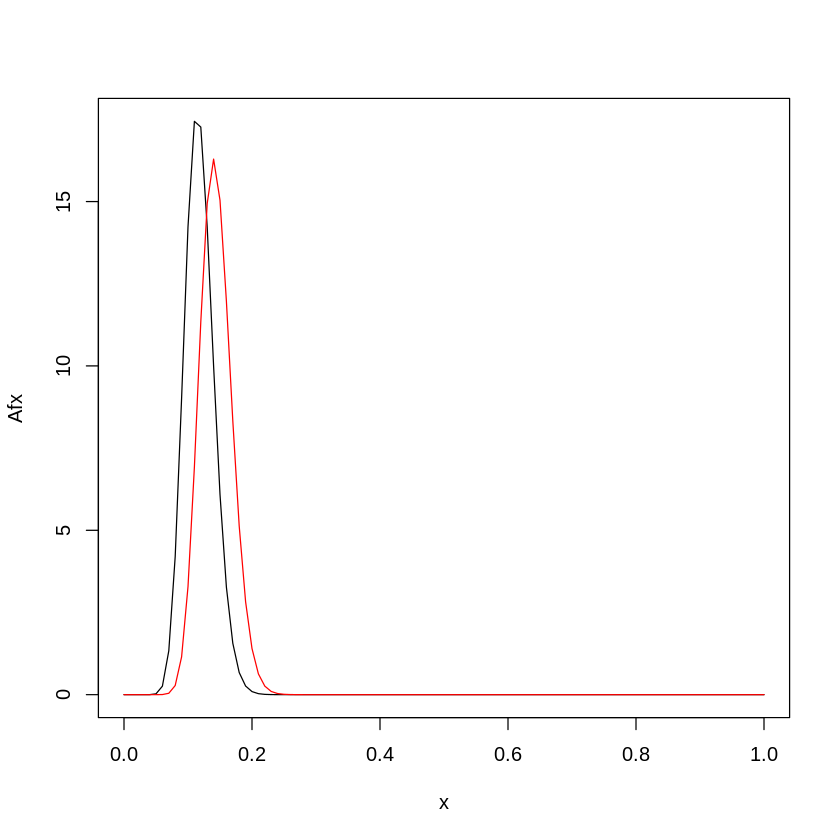

In [ ]:
x<-seq(0,1,0.01)
a=23+1
b=178+1
Afx<-dbeta(x, a, b)
a1=28+1
b1=172+1
Bfx<-dbeta(x, a1, b1)
plot(x, Afx, type="l") 
lines(x, Bfx, col="red")


A common way to compare these two proportions numerically is to randomly sample from each of the distributions and compute the number of times that the random draw from distribution A is greater than distribution B.  The number of times the random draw from distribution A exceeds B divided by the total number of draws approximates $P(p_A>p_B)$.


In [ ]:
iter=100000
a=23+1
b=177+1
a1=28+1
b1=172+1
count<-c()
for (i in 1:iter){
A<-rbeta(1, a, b)
B<-rbeta(1, a1, b1)
count[i]<-ifelse(A>B, 1, 0)


}
pdiff<-sum(count)/iter
pdiff

[1] 0.22715

This indicates that there is a 23% chance that the true success rate for A is greater than the true success rate for B.  Even though B is doing better based on the 400 emails, there is still about a one in four chance that A performs better than B in the long run.
 
Looks like we might want some more data.


Below is a picture of the results from Google Analytics Experiments and the column called "Probablity of Outperforming Orginial" is the same analysis that we just did above.

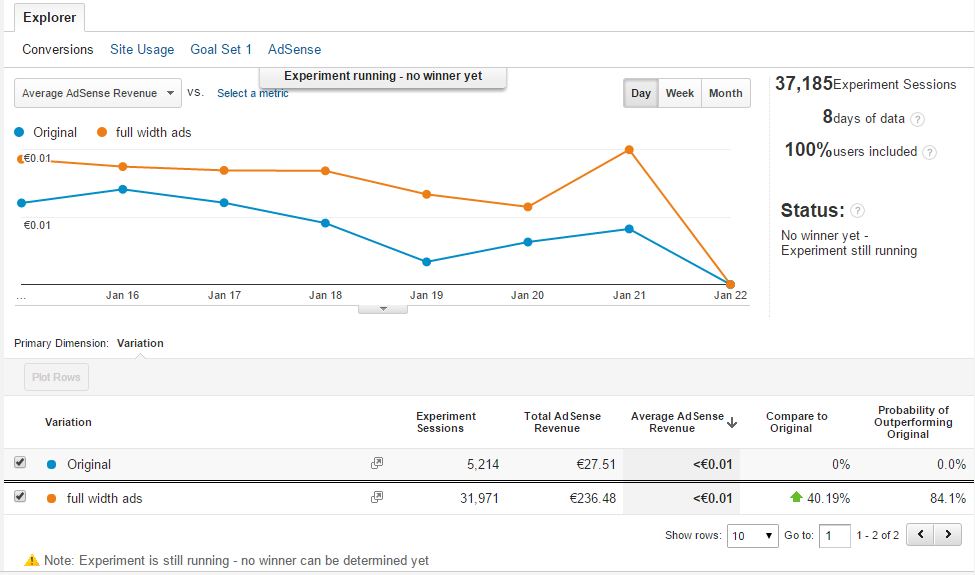